# Reinforcement Learning - Cross-Entropy Method

## What is Cross-Entropy?

Cross-Entropy is a way to measure how different two probability distributions are. Imagine you have a model that makes predictions, and you want to see how close these predictions are to the actual outcomes. Cross-Entropy gives a number that tells you how good your model is. A lower cross-entropy means your model's predictions are better.

**Simple Example:**

* Think of predicting the weather. If you say there's a 70% chance of rain and it actually rains, your prediction is pretty good. Cross-Entropy helps measure how accurate such predictions are.

## How Does RL Use Cross-Entropy?

In Reinforcement Learning (RL), an agent learns to make decisions by performing actions and receiving rewards. When RL uses Cross-Entropy, it helps the agent improve its actions based on past experiences.

**How It Works:**

* The agent tries different actions in an environment.
* It records which actions lead to good rewards.
* Using Cross-Entropy, it focuses more on the actions that gave better rewards.
* Over time, the agent gets better at choosing actions that maximize rewards.

## General Step-by-Step Process

Here’s a simple step-by-step guide on how RL with Cross-Entropy works:

1. **Initialize:** Start with a random policy (a set of rules the agent follows to decide actions).
2. **Generate Episodes:** Let the agent perform actions in the environment to create episodes (sequences of states, actions, and rewards).
3. **Evaluate:** Calculate the total rewards for each episode.
Select Top Performers: Choose the best-performing episodes based on their rewards.
4. **Update Policy:** Use Cross-Entropy to update the policy, making it more likely to choose actions that led to high rewards.
5. **Repeat:** Go back to step 2 and repeat the process until the agent performs well.

## Additional Information

* Advantages:
    * Simplicity: The Cross-Entropy method is straightforward and easy to implement.
    * Efficiency: It can find good solutions with fewer trials compared to other methods.


* Applications:
    * Robotics (teaching robots to perform tasks)
    * Game Playing (like training agents to play video games)
    * Optimization Problems (finding the best solutions in complex scenarios)

# Initial Environment Setup

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

Now I would like to check the graphics card

In [2]:
!nvidia-smi

Wed Oct  9 23:15:49 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1660 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   65C    P8              3W /   60W |     188MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Sep_12_02:55:00_Pacific_Daylight_Time_2024
Cuda compilation tools, release 12.6, V12.6.77
Build cuda_12.6.r12.6/compiler.34841621_0


In [4]:
import torch
print(torch.__version__)
print('Is CUDA available: ' + str(torch.cuda.is_available()))

2.4.1+cu124
Is CUDA available: True


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np

from collections import namedtuple
from tensorboardX import SummaryWriter
from pathlib import Path

# CartPole

The CartPole is one of the most basic environments available on gymnasium. This environment is well suit suitable to be used on this first example.

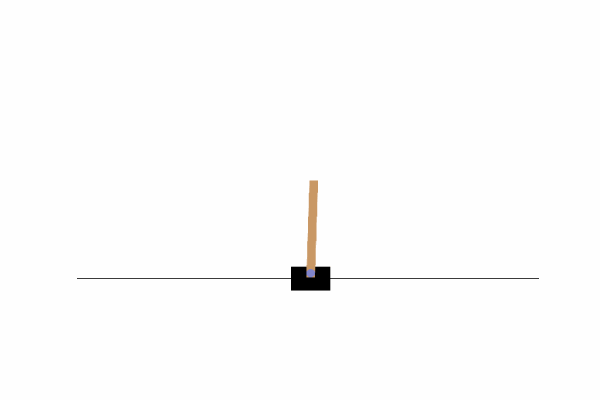

In [6]:
import gymnasium as gym
from IPython.display import Video, Image

from utils.wrappers import RecordGif

# RUN A RANDOM AGENT FOR DEMO PURPOSES
env = gym.make('CartPole-v1', render_mode='rgb_array')
env = RecordGif(env, f'./gifs/cartpole', gif_length=200, name_prefix='random-agent')

env.reset(seed=42)
for _ in range(200):
    env.step(env.action_space.sample())
env.close()

Image(filename=f'gifs/cartpole/random-agent-episode-0.gif', width=350, height=250)

This is a video of the cart pole environment being controlled by random actions.<br>
This environment consists in a pole being balanced by a cart who can move to left or right to keep the pole in a vertical position.<br>
The apisode ends when the pole cross a given angle, or the cart cross the environment boundaries. For every step the agent can keep the pole balanced, it will receive a positive reward.


The environment could look simple, but it is a good candidate to implement a reinforcement learning, cross-entropy, model. 

## Creating the function to yield the batches to train the model

This function is used to create the batches of data to train the model. The batches are set by running the Neural Network throught the environment steps, acumulate the rewards and group them in collections to use during the training steps.

In [7]:
# These named tuples are to store the experience of the agent
Episode = namedtuple('Episode', field_names=['reward', 'steps'])
EpisodeStep = namedtuple('EpisodeStep', field_names=['observation', 'action'])

# this is the function to create the batches
def training_batch(env: gym.Env, net: nn.Module, batch_size: int, device: str):
    '''
    This function will generate a batch of episodes from the environment.
    The batch will be of size batch_size.
    The neural network nn will be used to generate the actions.
    The device will be used to store the tensors.

    The function will yield a list of episodes of size batch_size.
    '''

    softmax = nn.Softmax(dim=1)
    batchs = []

    while True:
        for _ in range(batch_size):
            obs,_ = env.reset()

            total_reward = 0.0
            steps = []

            while True:
                obs_v = torch.FloatTensor([obs]).to(device)

                act_probs_v = softmax(net(obs_v))
                act_probs = act_probs_v.data.cpu().numpy()[0]
                action = np.random.choice(len(act_probs), p=act_probs)

                next_obs, reward, done, truncated, _ = env.step(action)
                steps.append(EpisodeStep(observation=obs, action=action))
                
                obs = next_obs
                total_reward += reward

                if done or truncated:
                    batchs.append(Episode(reward=total_reward, steps=steps))
                    break
        
        yield batchs

**Episode**: This tuple was defined to store the information of every episode. So for every run where our neural network is interacting with the environment we are acumulating the data in a instance of this tuple. The 'reward' field receives the total reward obtained during the episode, and the 'steps' field is to store a list of *EpisodeStep*.

**EpisodeStep**: This tuple was defined to store the information of a single step from the agent in the environment. So for every step we needs to create a new instance of this tuple to include in the *Episode*. The 'action' field is to store the action from the agent in the step, and the 'observation' field is to store the observation the agend did use to choose the action.

> It is important to notice here, the opservation we are includding in the EpisodeStep is the 'obs' the agent did use to choose an action and not the 'next_obs' we receive after the step.

**training_batch**: This function has the singlçe objective of run some episodes using the Neural Network agent to choose an action for every step from the episodes. Than it should acumulate the data from the episodes and return it as an yield value. We can use this function to get the batches we need during the training of the agent.

> You can see something interesting in the training_batch function. When we are choosing an action to step into the evrironment, we are not using the direct result from the Neural Network, we are using the probabilities generated by the Softmax activation function, and we are using these probabilities to choose a random action based on them. So while the agente is getting more confident to perform an action for a given scenario, this action will have more chances to be the chosen while we keep space for exploration.

> Another interesting point is we are using the Softmax outside of the newral network! We are doing it, because we not expecting to use it on our final agent, but it is supporting us to get the probabilities for every action, for every step, during the batch creation.


Ok, now we have a way to get batches to use during the training. But we still have to filter the top episodes to discard the ones with a bad performance. This is exactly what we are going to do next!

## Filtering the episodes to use for model training (choose the Elite episodes)

To ensure our agent will learn on good experences and ignore the bad ones, we have to... we... discard the bad experiences! We are looking for the Elite ones!

A technique to filter off the bad experiences is to define a minimun reward for an episode to include it on our training data. But should not be just an abritary value, and it has to adapt for every batch, since the average performance should increace over the time.

We can, instead of an abitrary value, organize the rewards in percentiles, and choose only the episodes whos reward is equals or higger than the value related to a given percentile we choose. So with this strategy, the value we use to filter episodes will adapt for every batch.

In [8]:
def filter_batch(batch: list[Episode], device: str, percentile:int = 70):
    '''
    This function will filter the batch of episodes.
    It will only keep the episodes that have a reward greater than the percentile.
    It will return the observations and the actions of the episodes.
    '''
    rewards = [ e.reward for e in batch ]
    reward_bound = np.percentile(rewards, percentile)
    reward_mean = float(np.mean(rewards))

    train_obs = []
    train_act = []

    for episode in batch:
        if episode.reward <= reward_bound:
            continue

        train_obs.extend([step.observation for step in episode.steps])
        train_act.extend([step.action for step in episode.steps])

    train_obs_v = torch.FloatTensor(train_obs).to(device)
    train_act_v = torch.LongTensor(train_act).to(device)

    return train_obs_v, train_act_v, reward_bound, reward_mean


Now our function to filter batches is going to find the reward value related to the percentile (70 defined as default), use this percentile to filter episodes, acumulate the opservations and actions and return the observation, action, the reward bound (the reward related to the given percentile) and the reward mean.

The reard bound and mean are just for metrics and they don't have any direct impact in the agent itself (well... we are going to use reward mean for early stop)

## The Agent (A Neural Network responsible by learn and run the episodes)

Now it is time to define our agent! This is basically a neural retwork who is going to learn with experiences and play the episodes of Cart Pole game!

In [9]:
class Net(nn.Module):
    def __init__(self, obs_size: int, hidden_size: int, n_actions: int):
        super(Net, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(obs_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, n_actions)
        )

    def forward(self, x):
        return self.net(x)

This Newral Network is pretty simple (we don't need anything to complex for Cart Pole game), we have 2 linear models, connected by a ReLU activation function.

The model definition is arbritary and could be structured in different ways, but this one should work for now.

# Training the Agent

We have now all the pieces we need to start training our agent.

In [ ]:
# DEFINE THE HYPERPARAMETERS
NN_HIDDEN_SIZE = 128
LEARNING_RATE = 0.01
BATCH_SIZE = 16

# DEFINE THE ENVIRONMENT
env = gym.make('CartPole-v1', render_mode='rgb_array')
env = RecordGif(env, './gifs/cartpole', name_prefix='training', gif_length=200, episode_trigger=lambda x: x % 500 == 0)

observation_size = env.observation_space.shape[0]
action_size = env.action_space.n

# DEFINE THE NETWORK
net = Net(observation_size, NN_HIDDEN_SIZE, action_size)

# DEFINE THE OPTIMIZER
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

# DEFINE THE LOSS FUNCTION
loss_fn = nn.CrossEntropyLoss()

# DEFINE THE DEVICE
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net.to(device)

# DEFINE THE WRITER
writer = SummaryWriter(logdir='runs/cart_pole', comment=f'-cartpole-pg')

# TRAIN THE AGENT
for iter_n, batch in enumerate(training_batch(env, net, BATCH_SIZE, device)):
    obs_v, acts_v, reward_b, reward_m = filter_batch(batch, device)

    optimizer.zero_grad()
    action_scores_v = net(obs_v)
    loss_v = loss_fn(action_scores_v, acts_v)
    loss_v.backward()
    optimizer.step()

    if iter_n % 25 == 0:
        print(f'{iter_n}: loss={loss_v.item()}, reward_bound={reward_b}, reward_mean={reward_m}')

    writer.add_scalar('loss', loss_v.item(), iter_n)
    writer.add_scalar('reward_bound', reward_b, iter_n)
    writer.add_scalar('reward_mean', reward_m, iter_n)

    if reward_m > 199:
        print(f'{iter_n}: loss={loss_v.item()}, reward_bound={reward_b}, reward_mean={reward_m}')
        print('Solved!')
        break

env.close()
writer.close()

0: loss=0.6880678534507751, reward_bound=28.0, reward_mean=23.3125


Took a while, but we have an Agent who can play the Cart Pole!

## Looking the metrics on tensorboad

The tensorboard is a tool used to record and read metrics from our models. Let's see our metrics!

<img src="./prints/tensorboard-cartpole.png" style="width: 1000px">

Using the tensorboard we can see the loss going down and the reward going up (reward is increacing almost linear hahahaha)

In [11]:
# saving the model
Path('models').mkdir(exist_ok=True)
torch.save(net.state_dict(), 'models/cartpole-pg.pth')

I'll create a final video of the agent playing the cart pole game!

In [ ]:
env = gym.make('CartPole-v1', render_mode='rgb_array')
env = RecordGif(env, './gifs/cartpole', name_prefix='model', gif_length=500)

net.load_state_dict(torch.load('models/cartpole-pg.pth'))
net.eval()

obs,_ = env.reset(seed=40)
while True:
    obs_v = torch.FloatTensor([obs]).to(device)
    action = torch.argmax(net(obs_v)).item()
    obs, reward, done, truncated, _ = env.step(action)
    if done or truncated:
        break

env.close()

Image('gifs/cartpole/model-episode-0.gif', width=350, height=250)

The agent is quite good!<br>
It will not be able to run indefinidelly (i know, I did test with different seeds ¬¬), since we did limit the episodes to 200 steps, so it is not expecting to deal with what comes next, but as the objective of this repository is to learn the concepts of reinforcement learning, I'm really happy with the results.
